## Fine tuning for classification 

This GPT is train to classify messages between spam and ham.

In [1]:
import GPT
import GPTC
import torch
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader

torch.manual_seed(123)

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

GPTC.download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

# Visualize the dataset
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [2]:
balanced_df = GPTC.create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [3]:
# Map labels to integers
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})   
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [4]:
train_df, validation_df, test_df = GPTC.random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Datasets and Dataloaders

To make sure all the messages have the same size, a paidding token will be added to the tokens that are shorter than the longest text. This token will be the "endoftext" as it doesn't change the meaning of the message. The final structure of the message will be: 

<|text|><|endoftext|><|endoftext|>...

In [5]:
tokenizer = GPT.create_tokenizer()

# Create the datasets
train_dataset = GPTC.SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)
val_dataset = GPTC.SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = GPTC.SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [6]:
num_workers = 0
batch_size = 8


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [7]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


In [8]:
from gpt_download import download_and_load_gpt2


device = GPT.get_device()

# Model cunfiguration
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # context 
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": True       # Query-key-value bias
}
gpt_c = GPT.GPTModel(GPT_CONFIG_124M)
gpt_c.eval()

# Load Weights from OpenAI
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
GPT.load_weights_into_gpt(gpt_c, params)
gpt_c.to(device)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

## Modifying the models output 

For a classification task, the models head should be changed. During this task we dont want to select a token from the vocabulary, but a class (one of two). For this, we have to change the head form a 50257 units to only two units, one for each class (ham or spam).

Also, for the fine tuning of the model, the first layer will be frozen (no parameter updates) so while the fine tuning process is perfomed this layers are not updated as they capture the 'semantics of the lenguaje'. Is more efficient only to update the last layers so they can 'learn' the specific classification task.

In [9]:
# Froze params 
for param in gpt_c.parameters():
    param.requires_grad = False

In [10]:
# Change the output class to only two
num_classes = 2
gpt_c.out_head = torch.nn.Linear(in_features=GPT_CONFIG_124M["emb_dim"], out_features=num_classes)

In [11]:
# Allow only trining for the last layers
# Output layer
for param in gpt_c.trf_blocks[-1].parameters():
    param.requires_grad = True

# Norm layer
for param in gpt_c.final_norm.parameters():
    param.requires_grad = True

Regarding the output, we oly take the last item as thats the one containing the "atenttion" of all the other tokens on the string and therefore is the one that contains all the information of the text and wil give the most accurate prediction of the correct class. 

In [12]:
import time
start_time = time.time()

optimizer = torch.optim.AdamW(gpt_c.parameters(), lr=5e-5, weight_decay=0.1)

gpt_c.to(device)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = GPTC.train_classifier_simple(
    gpt_c, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 0.736, Val loss 0.759
Ep 1 (Step 000050): Train loss 0.660, Val loss 0.663
Ep 1 (Step 000100): Train loss 0.641, Val loss 0.659
Training accuracy: 50.00% | Validation accuracy: 55.00%
Ep 2 (Step 000150): Train loss 0.538, Val loss 0.565
Ep 2 (Step 000200): Train loss 0.562, Val loss 0.588
Ep 2 (Step 000250): Train loss 0.434, Val loss 0.527
Training accuracy: 75.00% | Validation accuracy: 65.00%
Ep 3 (Step 000300): Train loss 0.438, Val loss 0.383
Ep 3 (Step 000350): Train loss 0.349, Val loss 0.522
Training accuracy: 82.50% | Validation accuracy: 67.50%
Ep 4 (Step 000400): Train loss 0.345, Val loss 0.569
Ep 4 (Step 000450): Train loss 0.299, Val loss 0.321
Ep 4 (Step 000500): Train loss 0.104, Val loss 0.179
Training accuracy: 87.50% | Validation accuracy: 85.00%
Ep 5 (Step 000550): Train loss 0.115, Val loss 0.134
Ep 5 (Step 000600): Train loss 0.110, Val loss 0.117
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 4.05 min

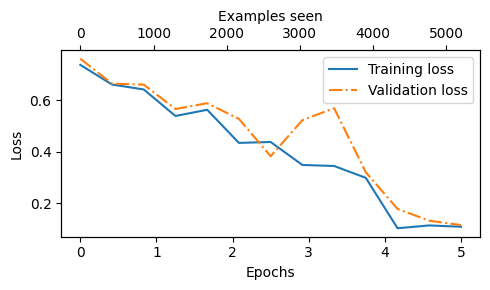

In [13]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

GPT.plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses, label="loss")

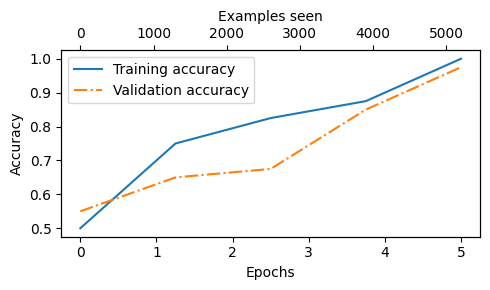

In [14]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

GPT.plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

In [15]:
train_accuracy = GPTC.calc_accuracy_loader(train_loader, gpt_c, device)
val_accuracy = GPTC.calc_accuracy_loader(val_loader, gpt_c, device)
test_accuracy = GPTC.calc_accuracy_loader(test_loader, gpt_c, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 96.15%
Validation accuracy: 95.97%
Test accuracy: 95.00%


## Try the model

In [16]:
text1 = ("You are a winner you have been specially selected to receive $1000 cash or a $2000 award.")
print(GPTC.classify_review(
  text1, gpt_c, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [17]:
text2 = ("Hey, just wanted to check if we're still on for dinner tonight? Let me know!")
print(GPTC.classify_review(
  text2, gpt_c, tokenizer, device, max_length=train_dataset.max_length
))


not spam


In [18]:
text_3 = ("Claim your $500 Amazon voucher before it expires. Start earning instantly!")
print(GPTC.classify_review(
  text_3, gpt_c, tokenizer, device, max_length=train_dataset.max_length
))


spam


In [19]:
torch.save(gpt_c.state_dict(), "classifier.pth")

""" Load the model """
# model_state_dict = torch.load("classifier.pth", map_location=device, weights_only=True)
# model.load_state_dict(model_state_dict)

' Load the model '